# Sunshine Duration Prediction with State-of-the-Art Machine Learning Models and Modern Tools

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

import os

# # change current working directory
# os.chdir('/content/gdrive/My Drive/MRP/')

In [3]:
# Create Directories
DIR_DATA = 'data/'
DIR_RAW = f'{DIR_DATA}raw_data/'
DIR_PROCESSED = f'{DIR_DATA}processed_data/'
DIR_FIGURES_EDA = 'eda_figures/'
DIR_RESULTS = 'results/'

for path in [DIR_RAW, DIR_PROCESSED, DIR_FIGURES_EDA, DIR_RESULTS]:

    if not os.path.exists(path):
            os.makedirs(path)

    if path == DIR_RESULTS:

        p_clean_experiments = f'{path}clean_experiments/'
        p_outlier_experiments = f'{path}outlier_experiments/'

        DIR_RESULTS_FIGURES_CLEAN = f'{p_clean_experiments}figures/'
        DIR_RESULTS_FIGURES_OUTLIERS = f'{p_outlier_experiments}figures/'
        DIR_HYPERPARAMS_CLEAN = f'{p_clean_experiments}hyperparam_tuning/'
        DIR_HYPERPARAMS_OUTLIERS= f'{p_outlier_experiments}hyperparam_tuning/'
        DIR_TRIALS_CLEAN = f'{DIR_HYPERPARAMS_CLEAN}trials/'
        DIR_TRIALS_OUTLIERS = f'{DIR_HYPERPARAMS_OUTLIERS}trials/'
        DIR_TRIALS_FIGS_CLEAN = f'{DIR_HYPERPARAMS_CLEAN}figures/'
        DIR_TRIALS_FIGS_OUTLIERS = f'{DIR_HYPERPARAMS_OUTLIERS}figures/'
        DIR_MODEL_RESULTS_CLEAN = f'{p_clean_experiments}model_results/'
        DIR_MODEL_RESULTS_OUTLIERS = f'{p_outlier_experiments}model_results/'
        DIR_MODELS_CLEAN = f'{p_clean_experiments}models/'
        DIR_MODELS_OUTLIERS = f'{p_outlier_experiments}models/'

        directories = [DIR_RESULTS_FIGURES_CLEAN, DIR_RESULTS_FIGURES_OUTLIERS,
                       DIR_HYPERPARAMS_CLEAN, DIR_HYPERPARAMS_OUTLIERS,
                       DIR_TRIALS_CLEAN, DIR_TRIALS_OUTLIERS,
                       DIR_TRIALS_FIGS_CLEAN, DIR_TRIALS_FIGS_OUTLIERS,
                       DIR_MODEL_RESULTS_CLEAN, DIR_MODEL_RESULTS_OUTLIERS,
                       DIR_MODELS_CLEAN, DIR_MODELS_OUTLIERS]

        for p in directories:
            if not os.path.exists(p):
                os.makedirs(p)

In [4]:
import warnings
warnings.filterwarnings("ignore")


import copy
import datetime
import importlib
# importlib.reload(vf)
# importlib.reload(pf)
import logging
logging.disable(logging.CRITICAL)
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly.graph_objs as go
import random
import requests
import seaborn as sns
import sys
import time
import torch

from darts import concatenate
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mae, rmse
from darts.models import RandomForest # all other model calls are handled in the processing_functions.py module
from darts.models.forecasting.baselines import NaiveDrift, NaiveSeasonal, NaiveMean, NaiveMovingAverage
from darts.utils.callbacks import TFMProgressBar
from darts.utils.utils import SeasonalityMode
from datetime import datetime as dt
# from plotly.subplots import make_subplots
from project_code import processing_functions as pf, visualization_functions as vf, hyperparam_search as hp
from sklearn.preprocessing import MinMaxScaler
# from tqdm.notebook import tqdm


pd.set_option('display.min_rows', None)



### Main Experiments


In [5]:
#TODO: DELETE
### TODO: DELETE CELL AFTER FINAL TESTS WITH N_EPOCHS_OVERRIDE
#todo: run

# data_bbm_outliers = pd.read_csv(f'{DIRECTORY_PROCESSED}data_bbm_outliers.csv', index_col='date')
# data_bbm_clean = pd.read_csv(f'{DIRECTORY_PROCESSED}data_bbm_clean.csv', index_col='date')
# FORECAST_HORIZONS = (1, 3, 7, 14, 28)
importlib.reload(pf)
SEED = 50
# MODEL_NAMES = {
#     'naive_drift': 'Naive Drift',
#     'ets': 'Exponential Smoothing',
#     'rf': 'Random Forest',
#     'xgboost': 'XGBoost',
#     'lgbm': 'LightGBM',
#     'lstm': 'LSTM',
#     'gru': 'GRU',
#     'nbeats': 'N-BEATS',
#     'nhits': 'N-HiTS'
# }

# # compile hyperparameter search results
# # hyperparams_file = f'{DIRECTORY_HYPERPARAMS}optuna_results.json'
# hyperparams = {}

# for name in MODEL_NAMES.keys():
#     if name in ['naive_drift', 'ets']:
#         continue
#     try:
#         hyperprms = pf.read_json_file(f'{DIRECTORY_HYPERPARAMS}optuna_results_{name}.json')
#         hyperparams.update(hyperprms)
#     except:
#         continue

# pf.post_results(hyperparams, hyperparams_file, mode='w')

# reformat the hyperparameter dictionary
# hyperparams = pf.read_json_file(f'{DIRECTORY_HYPERPARAMS}optuna_results.json') #TODO: DELETE
# hyparams_reformatted = pf.get_reformatted_hyperparams(hyperparams, forecast_horizons=FORECAST_HORIZONS)

# generate cut-off date for the experiments (i.e. the next 1-28 days after the cutoff will become test data)
cutoff_date = pf.generate_cutoff_date(start_date='2023-01-01', end_date='2023-12-03', seed=SEED, n=1)
cutoff_date2 = pf.generate_cutoff_date(start_date='2023-08-01', end_date='2023-08-31', seed=SEED, n=1)
print(f'\nThe randomly selected cutoff_date for the main experiments is: {cutoff_date}')
print(f'\nThe randomly selected cutoff_date for the main experiments w/ same month as validation is: {cutoff_date2}')


The randomly selected cutoff_date for the main experiments is: 2023-04-09

The randomly selected cutoff_date for the main experiments w/ same month as validation is: 2023-08-19


In [6]:
# Compile results 
april = cutoff_date 
august = cutoff_date2
outlier_condition = 'Hyperparam-Outlier'
clean_condition = 'Hyperparam-Clean'

DIR_APRIL_OUTL = f'{DIR_MODEL_RESULTS_OUTLIERS}cutoff_date={april}/'
DIR_APRIL_CL = f'{DIR_MODEL_RESULTS_CLEAN}cutoff_date={april}/'
DIR_AUGUST_OUTL = f'{DIR_MODEL_RESULTS_OUTLIERS}cutoff_date={august}/'


In [8]:
experiment_results = pd.read_csv(f'{DIR_RESULTS}experiment_results_compiled.csv')

### X. What was the performance difference between Optuna-derived num_epochs and epoch override of 100 (i.e. same as for the default)?


In [10]:
error_metric = 'rmse'

deep_tuned_apr_outl = experiment_results[(experiment_results['cutoff_date'] == april) \
                                             & (experiment_results['model_name_proper'].isin(['LSTM', 'GRU', 'N-BEATS', 'N-HiTS'])) \
                                             & (experiment_results['model_type'] == 'tuned') \
                                             & (experiment_results['experiment_condition'] == outlier_condition)]

deep_tuned_apr_cl = experiment_results[(experiment_results['cutoff_date'] == april) \
                                             & (experiment_results['model_name_proper'].isin(['LSTM', 'GRU', 'N-BEATS', 'N-HiTS'])) \
                                             & (experiment_results['model_type'] == 'tuned') \
                                             & (experiment_results['experiment_condition'] == clean_condition)]

deep_tuned_aug_outl = experiment_results[(experiment_results['cutoff_date'] == august) \
                                             & (experiment_results['model_name_proper'].isin(['LSTM', 'GRU', 'N-BEATS', 'N-HiTS'])) \
                                             & (experiment_results['model_type'] == 'tuned') \
                                             & (experiment_results['experiment_condition'] == outlier_condition)]


In [11]:
pd.set_option('display.max_colwidth', None)

deep_models = ['LSTM', 'GRU', 'N-BEATS', 'N-HiTS']

experiment_results['unique_id'] = experiment_results['model_name_fh'] + '-Outliers-' + experiment_results['has_outliers'].astype(str) + '-' \
                            + experiment_results['experiment_condition']  + '-' + experiment_results['cutoff_date']

deep_tuned = experiment_results[(experiment_results['model_name_proper'].isin(deep_models)) \
                                 & (experiment_results['model_type'] == 'tuned')]

overr_compar_rmse = deep_tuned[['unique_id', 'model_name_proper', 'has_outliers', 'has_n_epochs_override', error_metric]]\
                    .pivot_table(index=['unique_id', 'model_name_proper', 'has_outliers'], columns='has_n_epochs_override', values=error_metric)\
                    .reset_index()

overr_compar_rmse['best_model'] = overr_compar_rmse.apply(lambda row: 'No Epoch Override' if row[False] < row[True]
                                                  else 'Epoch Override',axis=1)

overr_compar_rmse.rename(columns={False: 'no_epoch_override', True: 'epoch_override'}, inplace=True)

print('\n\nWin Proportion')
print('----------')
display(overr_compar_rmse['best_model'].value_counts(normalize=True))



Win Proportion
----------


best_model
Epoch Override       0.62
No Epoch Override    0.38
Name: proportion, dtype: float64

62% of the cases displayed better results with the epoch override of 100, vs. the number of epochs suggested by the hyperparameter search. 

In [12]:
# Check for Null values 
best_models_df = experiment_results.merge(overr_compar_rmse[['unique_id', 'best_model']], how='left')
best_models_df[(best_models_df['model_type'] == 'tuned') & (experiment_results['rmse'].isna())]

,model_name_proper,model_name_fh,model_type,has_outliers,forecast_horizon,rmse,mae,n_epochs,has_n_epochs_override,training_time,hyp_search_time,best_val_rmse,total_time,experiment_condition,cutoff_date,FH,unique_id,best_model
165,N-BEATS,nbeats_tuned_generic_fh7,tuned,True,7,NaN,NaN,100.0,True,22.31,327.74,0.6381,350.05,Hyperparam-Outlier,2023-04-09,FH-7,nbeats_tuned_generic_fh7-Outliers-True-Hyperparam-Outlier-2023-04-09,Epoch Override


For some reason, this experimental case with the epoch override of 100 resulted in NaN values for both metrics. The best model in this case will be adjusted to 'No Epoch Override.'

In [13]:
best_models_df.loc[(best_models_df['model_type'] == 'tuned') & (experiment_results['rmse'].isna()), 'best_model'] = 'No Epoch Override'
best_models_df[(best_models_df['model_type'] == 'tuned') & (experiment_results['rmse'].isna())]

,model_name_proper,model_name_fh,model_type,has_outliers,forecast_horizon,rmse,mae,n_epochs,has_n_epochs_override,training_time,hyp_search_time,best_val_rmse,total_time,experiment_condition,cutoff_date,FH,unique_id,best_model
165,N-BEATS,nbeats_tuned_generic_fh7,tuned,True,7,NaN,NaN,100.0,True,22.31,327.74,0.6381,350.05,Hyperparam-Outlier,2023-04-09,FH-7,nbeats_tuned_generic_fh7-Outliers-True-Hyperparam-Outlier-2023-04-09,No Epoch Override


In [14]:
non_dl_models = ['Naive Drift', 'Exponential Smoothing', 'Random Forest', 'XGBoost', 'LightGBM']

best_models_df2 = best_models_df[( (best_models_df['model_type'] == 'default') | (best_models_df['model_name_proper'].isin(non_dl_models)) ) \
                                 | ( (best_models_df['model_type'] == 'tuned') & (best_models_df['model_name_proper'].isin(deep_models)) \
                                          & (best_models_df['has_n_epochs_override'] == True)  & (best_models_df['best_model'] == 'Epoch Override') )
                                 | ( (best_models_df['model_type'] == 'tuned') & (best_models_df['model_name_proper'].isin(deep_models)) \
                                          & (best_models_df['has_n_epochs_override'] == False)  & (best_models_df['best_model'] == 'No Epoch Override') )
                                ].reset_index(drop=True)  
                                # & (experiment_results['model_name_proper'].isin(['N-BEATS'])) \
                                # & (experiment_results['model_name_proper'].isin(['N-BEATS'])) ]

# Check that filtering was properly applied
cols = [ 'unique_id', 'model_name_proper', 'has_n_epochs_override', 'best_model',]
test = best_models_df2[(best_models_df2['model_name_proper'] == 'N-HiTS') \
                       & (best_models_df2['experiment_condition'] == 'Hyperparam-Outlier') \
                       & (best_models_df2['cutoff_date'] == april)]

test[cols].sort_values(by='unique_id').reset_index(drop=True)

,unique_id,model_name_proper,has_n_epochs_override,best_model
0,nhits_default_fh1-Outliers-False-Hyperparam-Outlier-2023-04-09,N-HiTS,False,NaN
1,nhits_default_fh1-Outliers-True-Hyperparam-Outlier-2023-04-09,N-HiTS,False,NaN
2,nhits_default_fh14-Outliers-False-Hyperparam-Outlier-2023-04-09,N-HiTS,False,NaN
3,nhits_default_fh14-Outliers-True-Hyperparam-Outlier-2023-04-09,N-HiTS,False,NaN
4,nhits_default_fh28-Outliers-False-Hyperparam-Outlier-2023-04-09,N-HiTS,False,NaN
5,nhits_default_fh28-Outliers-True-Hyperparam-Outlier-2023-04-09,N-HiTS,False,NaN
6,nhits_default_fh3-Outliers-False-Hyperparam-Outlier-2023-04-09,N-HiTS,False,NaN
7,nhits_default_fh3-Outliers-True-Hyperparam-Outlier-2023-04-09,N-HiTS,False,NaN
8,nhits_default_fh7-Outliers-False-Hyperparam-Outlier-2023-04-09,N-HiTS,False,NaN
9,nhits_default_fh7-Outliers-True-Hyperparam-Outlier-2023-04-09,N-HiTS,False,NaN


In [15]:
# Rename models for easier display
best_models_df2['model_name'] = best_models_df2.apply(lambda row: 'RF-T' if row['model_type'] == 'tuned' and row['model_name_proper'] == 'Random Forest'
                                                                  else 'RF-D' if row['model_type'] == 'default' and row['model_name_proper'] == 'Random Forest'
                                                                  else 'XGB-T' if row['model_type'] == 'tuned' and row['model_name_proper'] == 'XGBoost'
                                                                  else 'XGB-D' if row['model_type'] == 'default' and row['model_name_proper'] == 'XGBoost'
                                                                  else 'LGBM-T' if row['model_type'] == 'tuned' and row['model_name_proper'] == 'LightGBM'
                                                                  else 'LGBM-D' if row['model_type'] == 'default' and row['model_name_proper'] == 'LightGBM'
                                                                  else 'LSTM-T' if row['model_type'] == 'tuned' and row['model_name_proper'] == 'LSTM'
                                                                  else 'LSTM-D' if row['model_type'] == 'default' and row['model_name_proper'] == 'LSTM'
                                                                  else 'GRU-T' if row['model_type'] == 'tuned' and row['model_name_proper'] == 'GRU'
                                                                  else 'GRU-D' if row['model_type'] == 'default' and row['model_name_proper'] == 'GRU'
                                                                  else 'NBEATS-G' if 'generic' in row['model_name_fh'] and row['model_type'] == 'default'
                                                                  else 'NBEATS-I' if 'interpretable' in row['model_name_fh']
                                                                  else 'NBEATS-T' if row['model_type'] == 'tuned' and row['model_name_proper'] == 'N-BEATS'
                                                                  else 'NHiTS-T' if row['model_type'] == 'tuned' and row['model_name_proper'] == 'N-HiTS' 
                                                                  else 'NHiTS-D' if row['model_type'] == 'default' and row['model_name_proper'] == 'N-HiTS'
                                                                  else 'ES' if row['model_name_proper'] == 'Exponential Smoothing'
                                                                  else row['model_name_proper'],
                                                                  axis=1)

In [16]:
best_models_df2[best_models_df2['model_name_proper'] == 'N-BEATS'].head(3)

,model_name_proper,model_name_fh,model_type,has_outliers,forecast_horizon,rmse,mae,n_epochs,has_n_epochs_override,training_time,hyp_search_time,best_val_rmse,total_time,experiment_condition,cutoff_date,FH,unique_id,best_model,model_name
120,N-BEATS,nbeats_default_generic_fh1,default,True,1,0.0761,0.0761,100.0,False,29.786,NaN,NaN,29.786,Hyperparam-Outlier,2023-04-09,FH-1,nbeats_default_generic_fh1-Outliers-True-Hyperparam-Outlier-2023-04-09,NaN,NBEATS-G
121,N-BEATS,nbeats_default_generic_fh3,default,True,3,2.1794,1.9372,100.0,False,29.717,NaN,NaN,29.717,Hyperparam-Outlier,2023-04-09,FH-3,nbeats_default_generic_fh3-Outliers-True-Hyperparam-Outlier-2023-04-09,NaN,NBEATS-G
122,N-BEATS,nbeats_default_generic_fh7,default,True,7,1.8087,1.4847,100.0,False,30.052,NaN,NaN,30.052,Hyperparam-Outlier,2023-04-09,FH-7,nbeats_default_generic_fh7-Outliers-True-Hyperparam-Outlier-2023-04-09,NaN,NBEATS-G


### **X. What were the best and worst performing model variants for each of the forecast horizons?**


#### April

In [17]:
apr_data_outl_cond = best_models_df2[(best_models_df2['experiment_condition'] == outlier_condition) & (best_models_df2['cutoff_date'] == april)]
apr_data_cl_cond = best_models_df2[(best_models_df2['experiment_condition'] == clean_condition) & (best_models_df2['cutoff_date'] == april)]
aug_data_outl_cond = best_models_df2[(best_models_df2['experiment_condition'] == outlier_condition) & (best_models_df2['cutoff_date'] == august)]

required_columns = ['FH', 'model_name', 'has_outliers']
# error_metric = 'rmse'
index = ['has_outliers', 'model_name']
RMSE = 'rmse'
MAE = 'mae'


# Outlier Condition - April 
rmse_outl_apr_outlCond, rmse_clean_apr_outlCond = pf.generate_error_table(apr_data_outl_cond, required_columns, index, 
                                                          pivot_column='FH', error_metric=RMSE, outlier_split=True)

mae_outl_apr_outlCond, mae_clean_apr_outlCond = pf.generate_error_table(apr_data_outl_cond, required_columns, index, 
                                                        pivot_column='FH', error_metric=MAE, outlier_split=True)


# Clean Condition - April 
rmse_clean_apr_clCond = pf.generate_error_table(apr_data_cl_cond, required_columns, index, 
                                                          pivot_column='FH', error_metric=RMSE, outlier_split=False)

mae_clean_apr_clCond = pf.generate_error_table(apr_data_cl_cond, required_columns, index, 
                                                        pivot_column='FH', error_metric=MAE, outlier_split=False)


# Outlier Condition - August
rmse_outl_aug_outlCond, rmse_clean_aug_outlCond = pf.generate_error_table(aug_data_outl_cond, required_columns, index, 
                                                          pivot_column='FH', error_metric=RMSE, outlier_split=True)

mae_outl_aug_outlCond, mae_clean_aug_outlCond = pf.generate_error_table(aug_data_outl_cond, required_columns, index, 
                                                        pivot_column='FH', error_metric=MAE, outlier_split=True)


In [37]:
print(f'\n\n------------------ {outlier_condition} Condition - Outlier Dataset: April ------------------\n')
print('\n-------- RMSE --------\n')
test = pf.highlight_min_max(df=rmse_outl_apr_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False)
display(test)

print('\n-------- MAE --------\n')
display(pf.highlight_min_max(df=mae_outl_apr_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False))


print(f'\n\n------------------ {outlier_condition} Condition - Outlier Dataset: August ------------------\n')
print('\n-------- RMSE --------\n')
display(pf.highlight_min_max(df=rmse_outl_aug_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False))

print('\n-------- MAE --------\n')
# print('\n------------------ MAE for Outlier Dataset: August ------------------\n')
display(pf.highlight_min_max(df=mae_outl_aug_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False))




------------------ Hyperparam-Outlier Condition - Outlier Dataset: April ------------------


-------- RMSE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
ES,0.998,2.477,1.824,1.463,1.149,1.463,1.562
GRU-D,0.176,2.236,1.546,1.378,1.148,1.378,1.310
GRU-T,1.010,2.333,1.684,1.366,1.081,1.366,1.474
LGBM-D,0.248,1.847,1.637,1.391,1.246,1.391,1.293
LGBM-T,0.482,1.641,1.520,1.456,1.125,1.456,1.280
LSTM-D,0.198,2.122,1.579,1.371,1.192,1.371,1.306
LSTM-T,0.910,2.466,1.826,1.479,1.262,1.479,1.570
NBEATS-G,0.076,2.179,1.809,1.594,1.277,1.594,1.421
NBEATS-I,0.112,1.987,1.731,1.300,1.296,1.300,1.288



-------- MAE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
ES,0.998,2.291,1.559,1.139,0.907,1.139,1.339
GRU-D,0.176,1.925,1.323,1.146,0.979,1.146,1.116
GRU-T,1.010,2.138,1.450,1.104,0.837,1.104,1.274
LGBM-D,0.248,1.493,1.447,1.172,1.029,1.172,1.094
LGBM-T,0.482,1.342,1.365,1.135,0.937,1.135,1.066
LSTM-D,0.198,1.812,1.351,1.147,0.799,1.147,1.076
LSTM-T,0.910,2.259,1.504,1.185,0.824,1.185,1.311
NBEATS-G,0.076,1.937,1.485,1.126,0.894,1.126,1.107
NBEATS-I,0.112,1.707,1.462,1.035,0.953,1.035,1.051




------------------ Hyperparam-Outlier Condition - Outlier Dataset: August ------------------


-------- RMSE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
ES,1.271,1.405,1.425,1.318,1.370,1.370,1.360
GRU-D,0.543,1.446,1.002,1.001,0.764,1.001,0.959
GRU-T,0.467,2.041,1.095,0.961,0.777,0.961,1.050
LGBM-D,0.229,1.409,1.203,1.036,0.852,1.036,0.961
LGBM-T,0.903,1.575,1.104,1.086,0.841,1.086,1.099
LSTM-D,0.388,1.598,1.048,1.056,0.738,1.048,0.979
LSTM-T,0.065,1.908,1.086,0.942,0.723,0.942,0.944
NBEATS-G,0.807,1.495,1.205,1.070,0.764,1.070,1.069
NBEATS-I,0.223,1.952,1.157,1.077,0.736,1.077,1.037



-------- MAE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
ES,1.271,1.354,1.355,1.246,1.312,1.312,1.308
GRU-D,0.543,1.293,0.661,0.703,0.600,0.661,0.743
GRU-T,0.467,1.446,0.880,0.713,0.576,0.713,0.799
LGBM-D,0.229,1.170,0.907,0.835,0.696,0.835,0.779
LGBM-T,0.903,1.150,0.744,0.858,0.650,0.858,0.861
LSTM-D,0.388,1.061,0.762,0.698,0.551,0.698,0.693
LSTM-T,0.065,1.364,0.704,0.742,0.491,0.704,0.678
NBEATS-G,0.807,1.007,0.868,0.784,0.530,0.807,0.801
NBEATS-I,0.223,1.416,0.718,0.626,0.431,0.626,0.673


In [19]:
print(f'\n\n------------------ {outlier_condition} Condition - Clean Dataset: April ------------------\n')
print('\n-------- RMSE --------\n')
display(pf.highlight_min_max(df=rmse_clean_apr_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False))

print('\n-------- MAE --------\n')
display(pf.highlight_min_max(df=mae_clean_apr_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False))



print(f'\n\n------------------ {clean_condition} Condition - Clean Dataset: April ------------------\n')
print('\n-------- RMSE --------\n')
display(pf.highlight_min_max(df=rmse_clean_apr_clCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False))

print('\n-------- MAE --------\n')
display(pf.highlight_min_max(df=mae_clean_apr_clCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False))



print(f'\n\n------------------ {outlier_condition} Condition - Clean Dataset: August ------------------\n')
print('\n-------- RMSE --------\n')
display(pf.highlight_min_max(df=rmse_clean_aug_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False))

print('\n-------- MAE --------\n')
display(pf.highlight_min_max(df=mae_clean_aug_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=False))




------------------ Hyperparam-Outlier Condition - Clean Dataset: April ------------------


-------- RMSE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
ES,0.113,0.104,0.171,0.203,0.235,0.171,0.166
GRU-D,0.011,0.015,0.137,0.236,0.287,0.137,0.137
GRU-T,0.005,0.128,0.183,0.217,0.228,0.183,0.157
LGBM-D,0.136,0.228,0.179,0.236,0.246,0.228,0.209
LGBM-T,0.049,0.154,0.182,0.242,0.242,0.182,0.175
LSTM-D,0.014,0.046,0.202,0.258,0.242,0.202,0.161
LSTM-T,0.198,0.133,0.204,0.207,0.236,0.204,0.197
NBEATS-G,0.181,0.125,0.182,0.281,0.246,0.182,0.200
NBEATS-I,0.224,0.154,0.209,0.247,0.322,0.224,0.230



-------- MAE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
ES,0.113,0.104,0.132,0.175,0.212,0.132,0.145
GRU-D,0.011,0.014,0.119,0.206,0.229,0.119,0.116
GRU-T,0.005,0.115,0.110,0.187,0.198,0.115,0.122
LGBM-D,0.136,0.217,0.164,0.201,0.217,0.201,0.189
LGBM-T,0.049,0.154,0.162,0.216,0.177,0.162,0.153
LSTM-D,0.014,0.043,0.181,0.231,0.185,0.181,0.139
LSTM-T,0.198,0.131,0.186,0.177,0.189,0.186,0.178
NBEATS-G,0.181,0.124,0.151,0.221,0.219,0.181,0.180
NBEATS-I,0.224,0.153,0.133,0.161,0.244,0.161,0.179




------------------ Hyperparam-Clean Condition - Clean Dataset: April ------------------


-------- RMSE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
ES,0.113,0.104,0.171,0.203,0.235,0.171,0.166
GRU-T,0.322,0.116,0.282,0.217,0.230,0.230,0.233
LGBM-T,0.131,0.103,0.231,0.223,0.241,0.223,0.192
LSTM-T,0.063,0.060,0.204,0.200,0.235,0.200,0.160
NBEATS-T,0.148,0.344,0.265,0.344,0.283,0.283,0.278
NHiTS-T,0.048,0.050,0.209,0.204,0.214,0.204,0.155
Naive Drift,0.000,0.000,0.201,0.244,0.336,0.201,0.164
RF-T,0.191,0.253,0.291,0.229,0.233,0.233,0.238
XGB-T,0.226,0.150,0.154,0.236,0.246,0.226,0.206



-------- MAE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
ES,0.113,0.104,0.132,0.175,0.212,0.132,0.145
GRU-T,0.322,0.087,0.243,0.178,0.219,0.219,0.211
LGBM-T,0.131,0.099,0.211,0.199,0.178,0.178,0.166
LSTM-T,0.063,0.053,0.199,0.170,0.214,0.170,0.145
NBEATS-T,0.148,0.332,0.180,0.263,0.231,0.231,0.231
NHiTS-T,0.048,0.039,0.202,0.196,0.192,0.192,0.145
Naive Drift,0.000,0.000,0.100,0.141,0.243,0.100,0.098
RF-T,0.191,0.253,0.281,0.208,0.202,0.208,0.224
XGB-T,0.226,0.147,0.143,0.201,0.214,0.201,0.189




------------------ Hyperparam-Outlier Condition - Clean Dataset: August ------------------


-------- RMSE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
ES,0.670,0.469,0.625,0.636,0.730,0.636,0.628
GRU-D,0.396,0.470,0.422,0.425,0.369,0.422,0.417
GRU-T,0.598,0.409,0.557,0.409,0.354,0.409,0.456
LGBM-D,0.396,0.495,0.509,0.440,0.386,0.440,0.444
LGBM-T,0.423,0.433,0.403,0.417,0.363,0.417,0.409
LSTM-D,0.470,0.451,0.454,0.423,0.341,0.451,0.432
LSTM-T,0.455,0.646,0.411,0.422,0.344,0.422,0.450
NBEATS-G,0.390,0.534,0.423,0.489,0.420,0.423,0.447
NBEATS-I,0.306,0.434,0.420,0.420,0.352,0.420,0.392



-------- MAE --------



FH,FH-1,FH-3,FH-7,FH-14,FH-28,Median,Mean
model_name,,,,,,,
ES,0.670,0.440,0.551,0.573,0.660,0.573,0.578
GRU-D,0.396,0.407,0.389,0.382,0.330,0.389,0.382
GRU-T,0.598,0.358,0.508,0.361,0.286,0.361,0.412
LGBM-D,0.396,0.430,0.462,0.401,0.331,0.401,0.403
LGBM-T,0.423,0.375,0.364,0.381,0.324,0.375,0.374
LSTM-D,0.470,0.375,0.423,0.356,0.273,0.375,0.379
LSTM-T,0.455,0.532,0.352,0.374,0.292,0.374,0.397
NBEATS-G,0.390,0.412,0.371,0.377,0.298,0.377,0.371
NBEATS-I,0.306,0.408,0.384,0.382,0.302,0.382,0.361


In [20]:
## Latex Code for Report
print(f'\n\n------------------ {outlier_condition} Condition - Outlier Dataset: April RMSE ------------------\n')
_ = pf.highlight_min_max(df=rmse_outl_apr_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=True)


print(f'\n\n------------------ {outlier_condition} Condition - Outlier Dataset: August RMSE ------------------\n')
_ = pf.highlight_min_max(df=rmse_outl_aug_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=True)


print(f'\n\n------------------ {outlier_condition} Condition - Clean Dataset: April MAE ------------------\n')
_ = pf.highlight_min_max(df=mae_clean_apr_outlCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=True)

print(f'\n\n------------------ {clean_condition} Condition - Clean Dataset: April RMSE ------------------\n')
_ = pf.highlight_min_max(df=rmse_clean_apr_clCond, columns_to_drop=['has_outliers'], index_col='model_name', highlight_selection='all', print_latex=True)




------------------ Hyperparam-Outlier Condition - Outlier Dataset: April RMSE ------------------

Latex Version: 

\begin{tabular}{lrrrrrrr}
FH & FH-1 & FH-3 & FH-7 & FH-14 & FH-28 & Median & Mean \\
model_name &  &  &  &  &  &  &  \\
ES & 0.998 & 2.477 & 1.824 & 1.463 & 1.149 & 1.463 & 1.562 \\
GRU-D & 0.176 & 2.236 & 1.546 & 1.378 & 1.148 & 1.378 & 1.310 \\
GRU-T & 1.010 & 2.333 & 1.684 & 1.366 & \bfseries \color{darkgreen} 1.081 & 1.366 & 1.474 \\
LGBM-D & 0.248 & 1.847 & 1.637 & 1.391 & 1.246 & 1.391 & 1.293 \\
LGBM-T & 0.482 & 1.641 & 1.520 & 1.456 & 1.125 & 1.456 & 1.280 \\
LSTM-D & 0.198 & 2.122 & 1.579 & 1.371 & 1.192 & 1.371 & 1.306 \\
LSTM-T & 0.910 & 2.466 & \bfseries \color{firebrick} 1.826 & 1.479 & 1.262 & 1.479 & 1.570 \\
NBEATS-G & 0.076 & 2.179 & 1.809 & 1.594 & 1.277 & 1.594 & 1.421 \\
NBEATS-I & 0.112 & 1.987 & 1.731 & \bfseries \color{darkgreen} 1.300 & 1.296 & \bfseries \color{darkgreen} 1.300 & 1.288 \\
NBEATS-T & 0.592 & 2.326 & nan & 1.559 & 1.427 & 1.493 & 1.

### X. What is the performance differential for tuned vs. default model performance?

#### April

In [21]:
apr = apr_data_outl_cond[~(apr_data_outl_cond['model_name_proper'].isin(['Exponential Smoothing', 'Naive Drift']))]
apr_diff = apr[['FH', 'model_name_proper', 'has_outliers', 'model_type', error_metric]]\
                    .pivot_table(index=['model_name_proper', 'has_outliers'], columns='model_type', values=RMSE, aggfunc='mean')\
                    .reset_index()

apr_diff['diff'] = apr_diff['tuned'] - apr_diff['default']
apr_diff.sort_values(by='diff', ascending=False).reset_index(drop=True)

model_type,model_name_proper,has_outliers,default,tuned,diff
0,XGBoost,True,1.19482,1.65940,0.46458
1,LSTM,True,1.29238,1.58840,0.29602
2,GRU,True,1.29700,1.49498,0.19798
3,N-BEATS,False,0.21712,0.36074,0.14362
4,N-BEATS,True,1.33615,1.47610,0.13995
5,N-HiTS,False,0.12698,0.18382,0.05684
6,LSTM,False,0.15228,0.19572,0.04344
7,N-HiTS,True,1.43988,1.46510,0.02522
8,GRU,False,0.13716,0.15224,0.01508
9,XGBoost,False,0.21200,0.20928,-0.00272


In [22]:
print(f"On average, the tuned models' mean RMSE across all 5 forecast horizons is {apr_diff['diff'].mean():+.3f} vs. the default models' RMSE.")
print(f"There is a median difference of {apr_diff['diff'].median():+.3f} between the tuned models' mean RMSE vs. the default models'.")

On average, the tuned models' mean RMSE across all 5 forecast horizons is +0.083 vs. the default models' RMSE.
There is a median difference of +0.034 between the tuned models' mean RMSE vs. the default models'.


#### August

In [23]:
aug = aug_data_outl_cond[~(aug_data_outl_cond['model_name_proper'].isin(['Exponential Smoothing', 'Naive Drift']))]
aug_diff = aug[['FH', 'model_name_proper', 'has_outliers', 'model_type', error_metric]]\
                    .pivot_table(index=['model_name_proper', 'has_outliers'], columns='model_type', values=RMSE, aggfunc='mean')\
                    .reset_index()

aug_diff['diff'] = aug_diff['tuned'] - aug_diff['default']
aug_diff.sort_values(by='diff', ascending=False).reset_index(drop=True)

model_type,model_name_proper,has_outliers,default,tuned,diff
0,LightGBM,True,0.94578,1.10182,0.15604
1,Random Forest,True,0.93916,1.06910,0.12994
2,GRU,True,0.95102,1.06812,0.11710
3,XGBoost,False,0.43058,0.51880,0.08822
4,N-BEATS,True,1.04855,1.12968,0.08113
5,Random Forest,False,0.38824,0.45970,0.07146
6,GRU,False,0.41636,0.46570,0.04934
7,N-BEATS,False,0.41888,0.44846,0.02958
8,LSTM,False,0.42784,0.45540,0.02756
9,XGBoost,True,1.21738,1.23704,0.01966


In [24]:
print(f"On average, the tuned models' mean RMSE across all 5 forecast horizons is {aug_diff['diff'].mean():+.3f} vs. the default models' RMSE.")
print(f"There is a median difference of {aug_diff['diff'].median():+.3f} between the tuned models' mean RMSE vs. the default models'.")

On average, the tuned models' mean RMSE across all 5 forecast horizons is +0.045 vs. the default models' RMSE.
There is a median difference of +0.039 between the tuned models' mean RMSE vs. the default models'.


### X. What was the difference in tuned model performance for clean data for the Hyperparameter Clean vs. Hyperparameter Outlier Conditions?

#### April: Outlier Condition vs. Clean Condition 

In [25]:
apr_cl = apr_data_cl_cond[~(apr_data_cl_cond['model_name_proper'].isin(['Exponential Smoothing', 'Naive Drift']))]
apr_cl = apr_cl[['FH','model_name_proper', 'model_name_fh', 'has_outliers', 'model_type', RMSE]]\
                    .pivot_table(index=['FH','model_name_proper', 'model_name_fh', 'has_outliers'], columns='model_type', values=RMSE)\
                    .reset_index().loc[:, ['FH','model_name_proper', 'tuned']]
apr_cl['unique_id'] = apr_cl['model_name_proper'] + '-' +  apr_cl['FH']
apr_cl.rename(columns={'tuned':'clean_cond_tuned'}, inplace=True)

apr_outl = apr_data_outl_cond[~(apr_data_outl_cond['model_name_proper'].isin(['Exponential Smoothing', 'Naive Drift'])) &  ~ (apr_data_outl_cond['model_type'] == 'default') &  (apr_data_outl_cond['has_outliers'] == False)]
apr_outl = apr_outl[['FH','model_name_proper', 'model_name_fh', 'has_outliers', 'model_type', RMSE]]\
                    .pivot_table(index=['FH','model_name_proper', 'model_name_fh', 'has_outliers'], columns='model_type', values=RMSE)\
                    .reset_index().loc[:, ['FH','model_name_proper', 'tuned']]
apr_outl['unique_id'] = apr_outl['model_name_proper'] + '-' +  apr_outl['FH']
apr_outl.rename(columns={'tuned':'outlier_cond_tuned'}, inplace=True)

apr_tuned_comparison = apr_cl.merge(apr_outl[['unique_id', 'outlier_cond_tuned']], on=['unique_id'], how='inner').reset_index()
reordered_cols = ['unique_id', 'model_name_proper', 'FH', 'clean_cond_tuned', 'outlier_cond_tuned']
apr_tuned_comparison = apr_tuned_comparison[reordered_cols]

apr_tuned_comparison['diff'] = apr_tuned_comparison['clean_cond_tuned'] - apr_tuned_comparison['outlier_cond_tuned']
apr_tuned_comparison = apr_tuned_comparison.sort_values(by=['model_name_proper', 'diff'], ascending=[True, False])
apr_tuned_comparison.head()

model_type,unique_id,model_name_proper,FH,clean_cond_tuned,outlier_cond_tuned,diff
0,GRU-FH-1,GRU,FH-1,0.3218,0.0048,0.3170
28,GRU-FH-7,GRU,FH-7,0.2824,0.1831,0.0993
14,GRU-FH-28,GRU,FH-28,0.2302,0.2280,0.0022
7,GRU-FH-14,GRU,FH-14,0.2168,0.2172,-0.0004
21,GRU-FH-3,GRU,FH-3,0.1163,0.1281,-0.0118


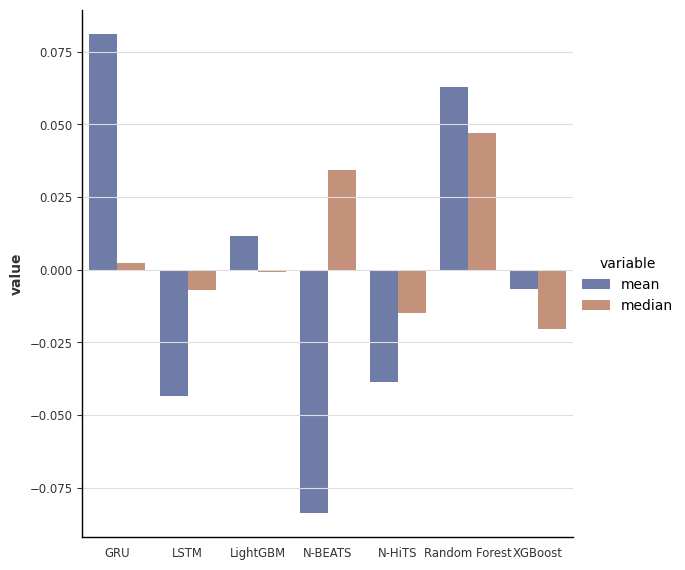

In [29]:
# apr_diff_median = apr_tuned_comparison[['model_name_proper', 'diff']].groupby(by=['model_name_proper']).median().reset_index()
# apr_diff_median.rename(columns={'diff': 'median'}, inplace=True)
# apr_diff_mean = apr_tuned_comparison[['model_name_proper', 'diff']].groupby(by=['model_name_proper']).mean().reset_index()
# apr_diff_mean.rename(columns={'diff': 'mean'}, inplace=True)


apr_diff = apr_tuned_comparison[['model_name_proper', 'diff']].groupby(by=['model_name_proper'])\
                                                   .agg(median = ('diff','median'), mean= ('diff','mean')).reset_index()

apr_diff = pd.melt(apr_diff, id_vars=['model_name_proper'], value_vars=['mean', 'median'])


tick_fontsize = 15
g = sns.catplot(
    data=apr_diff, kind="bar",
    x="model_name_proper", y="value", hue="variable",
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.set_xlabels('')


In [30]:
apr_data_outl_cond['model_name_proper'].unique()

array(['Naive Drift', 'Exponential Smoothing', 'Random Forest', 'XGBoost',
       'LightGBM', 'LSTM', 'GRU', 'N-BEATS', 'N-HiTS'], dtype=object)

### Was N-Hits Significantly more efficient than N-Beats? 

In [31]:
n_deep_models = apr_data_outl_cond[(apr_data_outl_cond['model_name_proper'].isin(['N-BEATS', 'N-HiTS']))].loc[:,['forecast_horizon','model_name', 'training_time', 'rmse']]
n_deep_models.head()

,forecast_horizon,model_name,training_time,rmse
120,1,NBEATS-G,29.786,0.0761
121,3,NBEATS-G,29.717,2.1794
122,7,NBEATS-G,30.052,1.8087
123,14,NBEATS-G,29.844,1.5937
124,28,NBEATS-G,30.301,1.2769


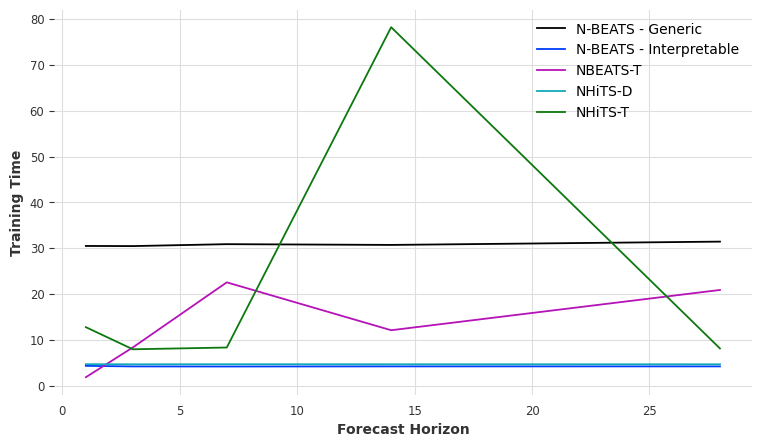

In [32]:
avg_rmse = n_deep_models.groupby(by=['model_name', 'forecast_horizon']).mean().reset_index()
avg_rmse['model_name2'] = avg_rmse.apply(lambda row: 'N-HiTS Default' if row['model_name'] == 'N-HiTS-D' 
                                                  else 'N-HiTS Tuned' if row['model_name'] == 'N-HiTS-TO' 
                                                  else 'N-BEATS - Generic' if row['model_name'] == 'NBEATS-G'
                                                  else 'N-BEATS - Interpretable' if row['model_name'] == 'NBEATS-I'
                                                  else 'N-BEATS - Tuned' if row['model_name'] == 'NBEATS-TO'
                                                  else row['model_name'],
                                                  axis=1)

fig, ax = plt.subplots(figsize=(9, 5))
g = sns.lineplot(data=avg_rmse, x='forecast_horizon', y='training_time', hue='model_name2')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.2, 1))
g.set_xlabel('Forecast Horizon')
g.set_ylabel('Training Time')
g.legend(title='')

fig.show()

In [36]:
median_rmse = n_deep_models.groupby(by=['model_name']).median().reset_index()
median_rmse['model_name2'] = median_rmse.apply(lambda row: 'N-HiTS - Default' if row['model_name'] == 'N-HiTS-D' 
                                                  else 'N-HiTS- Tuned' if row['model_name'] == 'N-HiTS-TO' 
                                                  else 'N-BEATS - Generic' if row['model_name'] == 'NBEATS-G'
                                                  else 'N-BEATS - Interpretable' if row['model_name'] == 'NBEATS-I'
                                                  else 'N-BEATS - Tuned' if row['model_name'] == 'NBEATS-TO'
                                                  else row['model_name'],
                                                  axis=1)

median_rmse = median_rmse.sort_values(by='rmse', ascending=True)

# import plotly.graph_objs as go
# from plotly.subplots import make_subplots

    
# fig, ax = plt.subplots(figsize=(10, 5))
# vf.dual_bar_chart(df=median_rmse, x='model_name2', y1='rmse', y2='training_time',
#                 y1_label='RMSE', y2_label='Training Time',y1_color='purple', y2_color='skyblue',
#                 font_size=14, align_axes=True, name='median_rmse_nbeats_nhits')

In [ ]:
print(f"On average, the tuned models' mean RMSE across all 5 forecast horizons is {aug_diff['diff'].mean():+.3f} vs. the default models' RMSE.")
print(f"There is a median difference of {aug_diff['diff'].median():+.3f} between the tuned models' mean RMSE vs. the default models'.")

### X. What were the best models of each type (i.e. Standard M/DL, Novel DL, Ensemble)? 

In [ ]:
best_models_outliers_rmse = ['Naive Drift', 'ES',  'GRU-TO', 'NBEATS-I', 'RF-D']
best_models_outliers_mae = ['Naive Drift', 'ES',  'GRU-TO', 'NBEATS-I', 'RF-T'] # only RF is diff from above
best_models_no_outl_rmse = ['Naive Drift', 'ES',  'GRU-D', 'NHiTS-D', 'LGBM-T']
best_models_no_outl_mae = ['Naive Drift', 'ES',  'GRU-TO', 'NHiTS-D', 'LGBM-T'] # GRU is the only one different


best_rmse_o = apr_data_outl_cond[(apr_data_outl_cond['model_name'].isin(best_models_outliers_rmse)) & (apr_data_outl_cond['has_outliers'] == True)]
best_mae_o = apr_data_outl_cond[(apr_data_outl_cond['model_name'].isin(best_models_outliers_mae)) & (apr_data_outl_cond['has_outliers'] == True)]
best_rmse_no = apr_data_outl_cond[(apr_data_outl_cond['model_name'].isin(best_models_no_outl_rmse)) & (apr_data_outl_cond['has_outliers'] == False)]
best_mae_no = apr_data_outl_cond[(apr_data_outl_cond['model_name'].isin(best_models_no_outl_mae)) & (apr_data_outl_cond['has_outliers'] == False)]

sns.set_style("whitegrid", {"grid.color": ".8", "grid.linestyle": ":"})
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
y_max1 = max(best_rmse_o['rmse'].max(), best_mae_o['mae'].max()) + .05
y_max2 = max(best_rmse_no['rmse'].max(), best_mae_no['mae'].max()) + .05

g1 = sns.lineplot(ax=axes[0], data=best_rmse_o, x='forecast_horizon', y='rmse', hue='model_name', 
                  style='model_name', marker='o')
g1.set_title('Top Models: Data with Outliers')
g1.set_xlabel('')
g1.set_ylabel('RMSE')
g1.set_ylim(0, y_max1)
g1.legend(loc='best', bbox_to_anchor=(1,1), borderaxespad=0)

g2 = sns.lineplot(ax=axes[1], data=best_rmse_no, x='forecast_horizon', y='rmse', hue='model_name', 
                  style='model_name', marker='o') 
g2.set_title('Top Models: Data without Outliers')
g2.set_xlabel('')
g2.set_ylabel('RMSE')
g2.set_ylim(0, y_max2)
g2.legend(loc='best', bbox_to_anchor=(1,1), borderaxespad=0)

fig.tight_layout()

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
g3 = sns.lineplot(ax=axes[0], data=best_mae_o, x='forecast_horizon', y='mae', hue='model_name', 
                  style='model_name', marker='o')
# g3.set_title('Top Models: Data with Outliers')
g3.set_xlabel('Forecast Horizon')
g3.set_ylabel('MAE')
g3.set_ylim(0, y_max1)
g3.legend(loc='best', bbox_to_anchor=(1,1), borderaxespad=0)

g4 = sns.lineplot(ax=axes[1], data=best_mae_no, x='forecast_horizon', y='mae', hue='model_name', 
                  style='model_name', marker='o') 
# g2.set_title('Top Models: Data without Outliers')
g4.set_xlabel('Forecast Horizon')
g4.set_ylabel('MAE')
g4.set_ylim(0, y_max2)
g4.legend(loc='best', bbox_to_anchor=(1,1), borderaxespad=0)

for direction in ['top', 'right', 'left']:
    g1.spines[direction].set_visible(False)
    g2.spines[direction].set_visible(False)
    g3.spines[direction].set_visible(False)
    g4.spines[direction].set_visible(False)

fig.tight_layout()



### Overall, how did the tuned models perform relative to the default models?

#### RMSE

In [ ]:
error_metric = 'rmse'

apr['model_name_proper'] = apr['model_name_proper'].replace('Random Forest', 'RF')
aug['model_name_proper'] = aug['model_name_proper'].replace('Random Forest', 'RF')

apr_diff_rmse = apr[['FH', 'model_name_proper', 'has_outliers', 'model_type', 'forecast_horizon', error_metric]]\
                    .pivot_table(index=['model_name_proper', 'has_outliers', 'forecast_horizon'], columns='model_type', values=error_metric)\
                    .reset_index()

apr_diff_rmse['best_model'] = apr_diff_rmse.apply(lambda row: 'Default' if row['default'] < row['tuned']
                                                  else 'Tuned',axis=1)


aug_diff_rmse = aug[['FH', 'model_name_proper', 'has_outliers', 'model_type', 'forecast_horizon', error_metric]]\
                    .pivot_table(index=['model_name_proper', 'has_outliers', 'forecast_horizon'], columns='model_type', values=error_metric)\
                    .reset_index()

aug_diff_rmse['best_model'] = aug_diff_rmse.apply(lambda row: 'Default' if row['default'] < row['tuned']
                                                  else 'Tuned',axis=1)




NameError: name 'apr_diff_rmse' is not defined

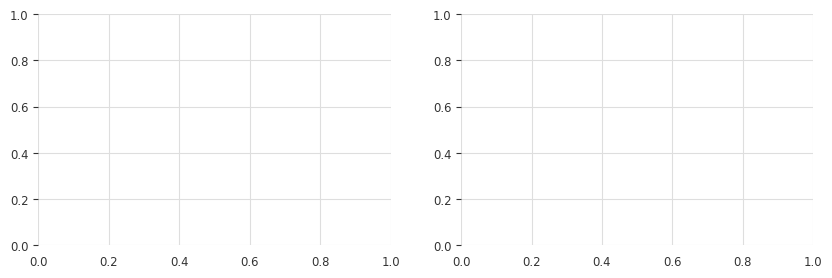

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
tick_fontsize = 15

g1 = sns.countplot(ax=axes[0], data=apr_diff_rmse, x='model_name_proper', hue='best_model',  
                   palette=['mediumblue', 'lightsteelblue'])
g1.set_title('RMSE: April Data')
g1.set_xlabel('')
g1.tick_params(axis='x', which='major', labelsize=9)
g1.set_ylabel('Percent', fontsize=12)
g1.tick_params(axis='y', which='major', labelsize=10)

g1.legend(loc='best', bbox_to_anchor=(1,1), borderaxespad=0)

g2 = sns.countplot(ax=axes[1], data=apr_diff_rmse, x='best_model', color='dodgerblue', stat='percent')
g2.set_xlabel('Best Model')
g2.set_ylabel('Percent', fontsize=12)
g2.tick_params(axis='x', which='major', labelsize=12)
g2.tick_params(axis='y', which='major', labelsize=10)

fig.tight_layout()

fig.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
g3 = sns.countplot(ax=axes[0], data=aug_diff_rmse, x='model_name_proper', hue='best_model', 
                   palette=['mediumblue', 'lightsteelblue'], hue_order=['Tuned', 'Default'])
g3.set_title('RMSE: August Data')
g3.set_xlabel('')
g3.tick_params(axis='x', which='major', labelsize=9)
g3.set_ylabel('Percent', fontsize=12)
g3.tick_params(axis='y', which='major', labelsize=10)
g3.legend(loc='best', bbox_to_anchor=(0.8,1), borderaxespad=0)

g4 = sns.countplot(ax=axes[1], data=aug_diff_rmse, x='best_model', color='dodgerblue', stat='percent',
                  order=['Tuned', 'Default'])
g4.set_xlabel('Best Model')
g4.set_ylabel('Percent', fontsize=12)
g4.tick_params(axis='x', which='major', labelsize=12)
g4.tick_params(axis='y', which='major', labelsize=10)

fig.tight_layout()

for direction in ['top', 'right', 'left']:
    g1.spines[direction].set_visible(False)
    g2.spines[direction].set_visible(False)
    g3.spines[direction].set_visible(False)
    g4.spines[direction].set_visible(False)
    
fig.show()



#### MAE

In [35]:
error_metric = 'mae'

apr_diff_mae = apr[['FH', 'model_name_proper', 'has_outliers', 'model_type', 'forecast_horizon', error_metric]]\
                    .pivot_table(index=['model_name_proper', 'has_outliers', 'forecast_horizon'], columns='model_type', values=error_metric)\
                    .reset_index()

apr_diff_mae['best_model'] = apr_diff_mae.apply(lambda row: 'Default' if row['default'] < row['tuned']
                                                  else 'Tuned',axis=1)

aug_diff_mae = aug[['FH', 'model_name_proper', 'has_outliers', 'model_type', 'forecast_horizon', error_metric]]\
                    .pivot_table(index=['model_name_proper', 'has_outliers', 'forecast_horizon'], columns='model_type', values=error_metric)\
                    .reset_index()

aug_diff_mae['best_model'] = aug_diff_mae.apply(lambda row: 'Default' if row['default'] < row['tuned']
                                                  else 'Tuned',axis=1)


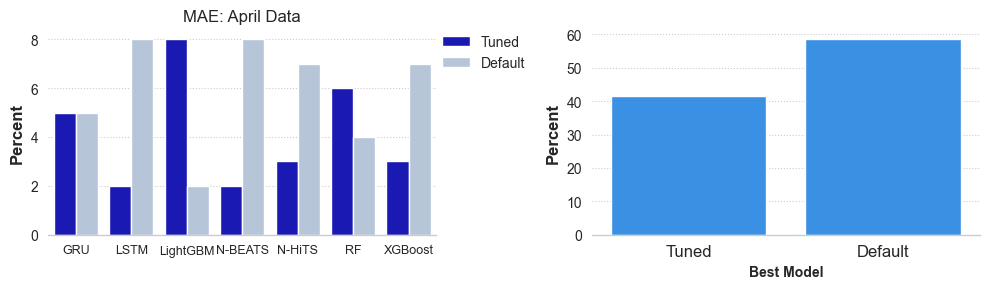

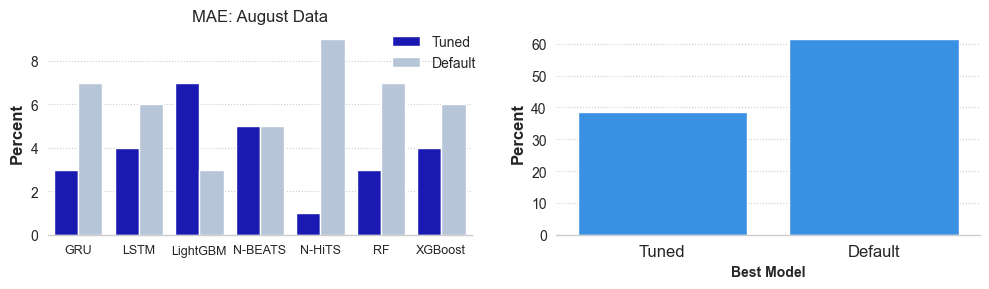

In [124]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
tick_fontsize = 15

g1 = sns.countplot(ax=axes[0], data=apr_diff_mae, x='model_name_proper', hue='best_model', 
                   palette=['mediumblue', 'lightsteelblue'])
g1.set_title('MAE: April Data')

g1.set_xlabel('')
g1.tick_params(axis='x', which='major', labelsize=9)
g1.set_ylabel('Percent', fontsize=12)
g1.tick_params(axis='y', which='major', labelsize=10)

g1.legend(loc='best', bbox_to_anchor=(1,1), borderaxespad=0)

g2 = sns.countplot(ax=axes[1], data=apr_diff_mae, x='best_model', color='dodgerblue', stat='percent')
g2.set_xlabel('Best Model')
g2.set_ylabel('Percent', fontsize=12)
g2.tick_params(axis='x', which='major', labelsize=12)
g2.tick_params(axis='y', which='major', labelsize=10)

fig.tight_layout()

fig.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 3))
g3 = sns.countplot(ax=axes[0], data=aug_diff_mae, x='model_name_proper', hue='best_model',
                   palette=['mediumblue', 'lightsteelblue'], hue_order=['Tuned', 'Default'])
g3.set_title('MAE: August Data')
g3.set_xlabel('')
g3.tick_params(axis='x', which='major', labelsize=9)
g3.set_ylabel('Percent', fontsize=12)
g3.tick_params(axis='y', which='major', labelsize=10)
g3.legend(loc='best', bbox_to_anchor=(0.8,1), borderaxespad=0)

g4 = sns.countplot(ax=axes[1], data=aug_diff_mae, x='best_model', color='dodgerblue', stat='percent',
                  order=['Tuned', 'Default'])
g4.set_xlabel('Best Model')
g4.set_ylabel('Percent', fontsize=12)
g4.tick_params(axis='x', which='major', labelsize=12)
g4.tick_params(axis='y', which='major', labelsize=10)

fig.tight_layout()

for direction in ['top', 'right', 'left']:
    g1.spines[direction].set_visible(False)
    g2.spines[direction].set_visible(False)
    g3.spines[direction].set_visible(False)
    g4.spines[direction].set_visible(False)
    
fig.show()

#TODO: choose diff colours 

### What was the difference between the train & test RMSEs?

In [373]:
# tuned_models = aug[aug['model_type'] ==  'tuned'].loc[:, ['model_name_proper', 'has_outliers', 'forecast_horizon', 'rmse', 'best_val_rmse', 'training_time']].reset_index(drop=True)
# tuned_models['rmse_difference'] = tuned_models['rmse'] - tuned_models['best_val_rmse']
# tuned_models

In [141]:
aug.columns

Index(['model_name_proper', 'model_name_fh', 'model_type', 'has_outliers',
       'forecast_horizon', 'rmse', 'mae', 'n_epochs', 'has_n_epochs_override',
       'training_time', 'hyp_search_time', 'best_val_rmse', 'total_time', 'FH',
       'cutoff_date', 'model_name'],
      dtype='object')

### X. Were the tuned models more performant at # of epochs derieved by Optuna or @ 100 epochs (i.e. same as default settings)?

In [ ]:
res_no_outliers.loc[res_no_outliers['model_name_proper'].isin(['Random Forest', 'XGBoost',
       'LightGBM', 'LSTM', 'GRU', 'N-BEATS', 'N-HiTS']) & (res_no_outliers['model_type'] == 'default'), ['model_name_proper', 'model_type', 'forecast_horizon',
                                                                                                     'rmse', 'mae', 'training_time', 'total_time']]

In [ ]:
# sns.set(style='white')
# errors = ['rmse', 'mae']

# for error in errors:

#     fig, ax = plt.subplots(figsize=(5, 3))
#     ax = sns.barplot(x='model_name', y=error, hue='has_n_epochs_override', data=tuned_median,
#                     palette=['purple', 'skyblue'])
#     ax.legend(bbox_to_anchor=(1.4,1), loc='upper right', borderaxespad=0, title='Epoch override')
#     ax.set_ylabel(f'Median {error.upper()} (h)')
#     ax.set_xlabel('')
#     sns.despine(top=True, right=True)

#     for bar in ax.patches:
#         # get height value to ensure annotation is at the top of the chart
#         bar_value = bar.get_height()
#         text = f'{bar_value:.3f}' if bar_value != 0 else ''
#         # get the middle of each bar on the x-axis for centered positioning
#         text_x = bar.get_x() + bar.get_width() / 2
#         # bar starts at get_y() position, so we add the height to it
#         text_y = bar.get_y() + bar_value
#         ax.text(text_x, text_y, text, ha='center',
#                 size=9)
#     plt.show()


In [ ]:
best_models_out

,model_name_proper,model_name_fh,model_type,has_outliers,forecast_horizon,rmse,mae,n_epochs,has_n_epochs_override,training_time,hyp_search_time,best_val_rmse,total_time,model_name,FH
0,Naive Drift,naive_drift_fh1,default,True,1,0.4735,0.4735,NaN,False,0.000,NaN,NaN,0.000,Naive Drift,FH-1
1,Naive Drift,naive_drift_fh3,default,True,3,1.2839,1.1548,NaN,False,0.000,NaN,NaN,0.000,Naive Drift,FH-3
2,Naive Drift,naive_drift_fh7,default,True,7,1.5910,1.4205,NaN,False,0.000,NaN,NaN,0.000,Naive Drift,FH-7
3,Naive Drift,naive_drift_fh14,default,True,14,1.6892,1.5602,NaN,False,0.000,NaN,NaN,0.000,Naive Drift,FH-14
4,Naive Drift,naive_drift_fh28,default,True,28,1.8723,1.7564,NaN,False,0.000,NaN,NaN,0.000,Naive Drift,FH-28
5,Exponential Smoothing,ets_fh1,default,True,1,0.9977,0.9977,NaN,False,0.321,NaN,NaN,0.321,Exponential Smoothing,FH-1
6,Exponential Smoothing,ets_fh3,default,True,3,2.4765,2.2905,NaN,False,0.287,NaN,NaN,0.287,Exponential Smoothing,FH-3
7,Exponential Smoothing,ets_fh7,default,True,7,1.8240,1.5593,NaN,False,0.292,NaN,NaN,0.292,Exponential Smoothing,FH-7
8,Exponential Smoothing,ets_fh14,default,True,14,1.4630,1.1393,NaN,False,0.287,NaN,NaN,0.287,Exponential Smoothing,FH-14
9,Exponential Smoothing,ets_fh28,default,True,28,1.1491,0.9074,NaN,False,0.287,NaN,NaN,0.287,Exponential Smoothing,FH-28


In [ ]:
sns.set(style='white')
fig, ax = plt.subplots(figsize=(6, 3))


# transform table from wide to long
rmse_melted = res_outliers_avg[['model_name', 'rmse', 'best_val_rmse', ]].melt(id_vars='model_name')
print('Transformed Long Table:\n\n')
display(rmse_melted.tail(3))
print('\n\n')
rmse_melted = rmse_melted.loc[rmse_melted['model_name'] != 'Exponential Smoothing']
rmse_melted.loc[rmse_melted['variable'] == 'rmse', 'variable'] = 'Avg Test RMSE'
rmse_melted.loc[rmse_melted['variable'] == 'best_val_rmse', 'variable'] = 'Avg Validation RMSE'
ax = sns.barplot(x='model_name', y='value', hue='variable', data=rmse_melted, palette=['purple', 'skyblue'])
ax.legend(bbox_to_anchor=(1.01,1), loc='upper left', borderaxespad=0)


# plot avg rmse vs. avg best validation rmse
for bar in ax.patches:
    # get height value to ensure annotation is at the top of the chart
    bar_value = bar.get_height()
    text = f'{bar_value:.2f}' if bar_value != 0 else '' # TESTING TO REMOVE 0.00
    # get the middle of each bar on the x-axis for centered positioning
    text_x = bar.get_x() + bar.get_width() / 2
    # bar starts at get_y() position, so we add the height to it
    text_y = bar.get_y() + bar_value
    ax.text(text_x, text_y, text, ha='center',
            size=9)


sns.despine(top=True, right=True)

# rmse_melted
ax.set_ylabel('RMSE')
ax.set_xlabel('')
plt.xticks(rotation=45)
plt.savefig(f'{DIRECTORY_RESULTS}avg_val_vs_test_rmse')
plt.show()



In [ ]:
rmse_comparison = res_outliers_avg[['model_name','best_val_rmse', 'rmse']]
rmse_comparison['rmse_diff'] = rmse_comparison['rmse'] - rmse_comparison['best_val_rmse']
rmse_comparison.set_index('model_name', inplace=True)
rmse_comparison.drop('Exponential Smoothing', inplace=True)
rmse_comparison.rename(columns={
                                'best_val_rmse': 'avg_val_rmse',
                                'rmse': 'avg_test_rmse'
                                    })
rmse_comparison.sort_values(by='rmse_diff', ascending=False)

rmse_comparison

In [211]:
!pwd

/Users/Keji1/Library/CloudStorage/OneDrive-Personal/Education/Toronto Metropolitan University/MSc Data Science/MRP & Research/MRP_results


In [232]:
DIRECTORY_RESULTS = 'results/'
DIRECTORY_MODELS = 'models/'
DIRECTORY_RAW = 'data/raw_data/'
DIRECTORY_PROCESSED = 'data/processed_data/'
DIRECTORY_MODEL_RESULTS = f'{DIRECTORY_RESULTS}model_results/'

# cutoff_date = '2023-08-19'

In [224]:
#python program to check if a directory exists
import os
path = f'{DIRECTORY_MODEL_RESULTS}cutoff_date={cutoff_date}/'

# Check whether the specified path exists or not
if not os.path.exists(path):
    print('folder does not exist')
    os.makedirs(path)
    print(f"Created Directory {path}!")



In [ ]:
##  DISCARDED CODE 



# overr_compar_apr_outl = deep_tuned_apr_outl[['FH', 'model_name_proper', 'has_outliers', 'has_n_epochs_override', error_metric]]\
#                     .pivot_table(index=['model_name_proper', 'has_outliers'], columns='has_n_epochs_override', values=error_metric, aggfunc='mean')\
#                     .reset_index()


# overr_compar_apr_cl = deep_tuned_apr_cl[['FH', 'model_name_proper', 'has_outliers', 'has_n_epochs_override', error_metric]]\
#                     .pivot_table(index=['model_name_proper', 'has_outliers'], columns='has_n_epochs_override', values=error_metric, aggfunc='mean')\
#                     .reset_index()

# overr_compar_aug_outl = deep_tuned_aug_outl[['FH', 'model_name_proper', 'has_outliers', 'has_n_epochs_override', error_metric]]\
#                     .pivot_table(index=['model_name_proper', 'has_outliers'], columns='has_n_epochs_override', values=error_metric, aggfunc='mean')\
#                     .reset_index()


# overr_compar_apr_outl['difference'] = overr_compar_apr_outl[True] - overr_compar_apr_outl[False]
# overr_compar_apr_cl['difference'] = overr_compar_apr_cl[True] - overr_compar_apr_cl[False]
# overr_compar_aug_outl['difference'] = overr_compar_aug_outl[True] - overr_compar_aug_outl[False]


# print(f'\nAverage RMSE: April - {outlier_condition} Condition\n')
# display(overr_compar_apr_outl)

# print(f'\nAverage RMSE: April - {clean_condition} Condition\n')
# display(overr_compar_apr_cl)


# print(f'\nAverage RMSE: August - {outlier_condition} Condition\n')
# display(overr_compar_aug_outl)


# print('April Results:')
# print(f"On average, there is an RMSE difference of {overr_compar_apr_outl['difference'].mean():.3f} between the two conditions (i.e. Override RMSE of 100 - No Override RMSE).")
# print(f"There is a median RMSE difference of {overr_compar_apr_outl['difference'].median():.3f} between the two conditions.")

# print('\nAugust Results:')
# print(f"On average, there is an RMSE difference of {overr_compar_aug_outl['difference'].mean():.3f} between the two conditions (i.e. Override RMSE of 100 - No Override RMSE).")
# print(f"There is a median RMSE difference of {overr_compar_aug_outl['difference'].median():.3f} between the two conditions.")



# overr_compar_apr_rmse_outl = deep_tuned_apr_outl[['forecast_horizon', 'model_name_proper', 'has_outliers','has_n_epochs_override', error_metric]]\
#                     .pivot_table(index=['model_name_proper', 'forecast_horizon', 'has_outliers'], columns='has_n_epochs_override', values=error_metric)\
#                     .reset_index()

# overr_compar_aug_rmse_outl = deep_tuned_aug_outl[['forecast_horizon', 'model_name_proper', 'has_outliers','has_n_epochs_override', error_metric]]\
#                     .pivot_table(index=['model_name_proper','forecast_horizon','has_outliers'], columns='has_n_epochs_override', values=error_metric)\
#                     .reset_index()

In [245]:
# required_columns = ['FH', 'model_name', 'has_outliers']
# error_metric = 'rmse'
# index = ['has_outliers', 'model_name']

# rmse_outl_apr_outlCond, rmse_clean_apr_outlCond = pf.generate_error_table(apr_data_outl_cond, required_columns, index, 
#                                                           pivot_column='FH', error_metric='rmse', outlier_split=True)
# mae_outl_apr_outlCond, mae_clean_apr_outlCond = pf.generate_error_table(apr_data_outl_cond, required_columns, index, 
#                                                         pivot_column='FH', error_metric='mae', outlier_split=True)


# rmse_outl_aug_outlCond, rmse_no_outliers_aug = pf.generate_error_table(aug_data_outl_cond, required_columns, index, 
#                                                           pivot_column='FH', error_metric='rmse', outlier_split=True)
# mae_outl_aug_outlCond, mae_no_outliers_aug = pf.generate_error_table(aug_data_outl_cond, required_columns, index, 
#                                                         pivot_column='FH', error_metric='mae', outlier_split=True)


In [113]:
# # alternative way of assessing whether n_epoch override was better performing

# error_metric = 'rmse'

# overr_compar_apr_outl_rmse = deep_tuned_apr_outl[['model_name_fh', 'model_name_proper', 'has_outliers', 'has_n_epochs_override', error_metric]]\
#                     .pivot_table(index=['model_name_proper','model_name_fh', 'has_outliers'], columns='has_n_epochs_override', values=error_metric)\
#                     .reset_index()


# overr_compar_apr_cl_rmse = deep_tuned_apr_cl[['model_name_fh', 'model_name_proper', 'has_outliers', 'has_n_epochs_override', error_metric]]\
#                     .pivot_table(index=['model_name_proper','model_name_fh', 'has_outliers'], columns='has_n_epochs_override', values=error_metric)\
#                     .reset_index()

# overr_compar_aug_outl_rmse = deep_tuned_aug_outl[['model_name_fh', 'model_name_proper', 'has_outliers', 'has_n_epochs_override', error_metric]]\
#                     .pivot_table(index=['model_name_proper','model_name_fh', 'has_outliers'], columns='has_n_epochs_override', values=error_metric)\
#                     .reset_index()

# overr_compar_apr_outl_rmse['best_model'] = overr_compar_apr_outl_rmse.apply(lambda row: 'No Epoch Override' if row[False] < row[True]
#                                                   else 'Epoch Override',axis=1)

# overr_compar_apr_cl_rmse['best_model'] = overr_compar_apr_cl_rmse.apply(lambda row: 'No Epoch Override' if row[False] < row[True]
#                                                   else 'Epoch Override',axis=1)


# overr_compar_aug_outl_rmse['best_model'] = overr_compar_aug_outl_rmse.apply(lambda row: 'No Epoch Override' if row[False] < row[True]
#                                                   else 'Epoch Override',axis=1)

# overr_compar_apr_outl_rmse.rename(columns={False: 'no_epoch_override', True: 'epoch_override'}, inplace=True)
# overr_compar_apr_cl_rmse.rename(columns={False: 'no_epoch_override', True: 'epoch_override'}, inplace=True)
# overr_compar_aug_outl_rmse.rename(columns={False: 'no_epoch_override', True: 'epoch_override'}, inplace=True)


# print(f'\n\nWin Proportion - April {outlier_condition} Condition')
# print('----------')
# display(overr_compar_apr_rmse_outl['best_model'].value_counts(normalize=True))

# print(f'\n\nWin Proportion - April {clean_condition} Condition')
# print('----------')
# display(overr_compar_apr_cl_rmse['best_model'].value_counts(normalize=True))

# print(f'\n\nWin Proportion - August {outlier_condition} Condition')
# print('----------')
# display(overr_compar_aug_outl_rmse['best_model'].value_counts(normalize=True))




Win Proportion - April Hyperparam-Outlier Condition
----------


best_model
Epoch Override       0.625
No Epoch Override    0.375
Name: proportion, dtype: float64



Win Proportion - April Hyperparam-Clean Condition
----------


best_model
Epoch Override       0.55
No Epoch Override    0.45
Name: proportion, dtype: float64



Win Proportion - August Hyperparam-Outlier Condition
----------


best_model
Epoch Override       0.65
No Epoch Override    0.35
Name: proportion, dtype: float64

In [ ]:
# HYPERPARAM COMPILATION 

# ### TODO: DELETE CELL
# data_bbm_outliers = pd.read_csv(f'{DIR_PROCESSED}data_bbm_outliers.csv', index_col='date')
# data_bbm_clean = pd.read_csv(f'{DIR_PROCESSED}data_bbm_clean.csv', index_col='date')
# #TODO: REMOVE ALL ABOVE  LINES

# # importlib.reload(pf)
SEED = 50
MODEL_NAMES = {
    'naive_drift': 'Naive Drift',
    'ets': 'Exponential Smoothing',
    'rf': 'Random Forest',
    'xgboost': 'XGBoost',
    'lgbm': 'LightGBM',
    'lstm': 'LSTM',
    'gru': 'GRU',
    'nbeats': 'N-BEATS',
    'nhits': 'N-HiTS'
}

# # compile hyperparameter search results
# hyperparams_file = f'{DIR_HYPERPARAMS}optuna_results.json'

name = 'gru'
hyperparams_file = f'{DIR_HYPERPARAMS_CLEAN}optuna_results_{name}_cleanversion.json'
# hyperparams = pf.read_json_file(f'{DIR_HYPERPARAMS}optuna_results.json') #TODO: DELETE
hyperparams = pf.read_json_file(hyperparams_file) #TODO: DELETE


# hyperparams = {}

# # for name in MODEL_NAMES.keys():
# for name in [name]:
#     hyperparams_file = f'{DIR_HYPERPARAMS}optuna_results_{name}_cleanedversion.json'

#     if name in ['naive_drift', 'ets']:
#         continue
#     try:
#         one_and_three = pf.read_json_file(f'{DIR_HYPERPARAMS}optuna_results_{name}_cleanedversion_1&3.json')
#         seven = pf.read_json_file(f'{DIR_HYPERPARAMS}optuna_results_{name}_cleanedversion_7.json')
#         fourteen = pf.read_json_file(f'{DIR_HYPERPARAMS}optuna_results_{name}_cleanedversion_14.json')
#         twenty_eight = pf.read_json_file(f'{DIR_HYPERPARAMS}optuna_results_{name}_cleanedversion_28.json')

#         hyperparams.update(one_and_three)
#         hyperparams.update(seven)
#         hyperparams.update(fourteen)
#         hyperparams.update(twenty_eight)
#         # hyperparams.update(hyperprms)
#     except:
#         continue

# pf.post_results(hyperparams, hyperparams_file, mode='w')

# # reformat the hyperparameter dictionary
hyparams_reformatted = pf.get_reformatted_hyperparams(hyperparams, forecast_horizons=FORECAST_HORIZONS)

# generate cut-off date for the experiments (i.e. the next 1-28 days after the cutoff will become test data)
cutoff_date = pf.generate_cutoff_date(start_date='2023-01-01', end_date='2023-12-03', seed=SEED, n=1)
cutoff_date2 = pf.generate_cutoff_date(start_date='2023-08-01', end_date='2023-08-31', seed=SEED, n=1)
print(f'\nThe randomly selected cutoff_date for the main experiments is: {cutoff_date}')
print(f'\nThe randomly selected cutoff_date for the main experiments w/ same month as validation is: {cutoff_date2}')

hyparams_reformatted
